# Project -- Analysing IRA tweets --

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import matplotlib.pyplot as plt
import glob

import findspark
findspark.init()

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import to_timestamp, isnan
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
import warnings # comment if you want to get the warnings from Searborn... ;) 
warnings.filterwarnings("ignore")

In [3]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this current *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **DESCRIPTIVE STATISTICS AND PROJECT FEASABILITY**. In this part of the notebook we want to give summary statistics about the datasets we will need the most for our project. Furthermore we will try to figure out whether or not our objectives of Milestone 1 are still feasible after the reading of our datasets. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [4]:
# taking IRAN tweets into account or not 
include_iran = False

In [5]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [6]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [7]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [8]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [9]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [10]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [11]:
# (a view is not adapted in the current context)
# tweets_stats_df.show(10)

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [12]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [13]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [14]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [15]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [16]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [17]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [18]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [19]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Furthermore, several of them are repeated. We thus consider it rather useless and prefer dropping it.

@answer : **REPEATED, is it really BAD ?** 

In [20]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (which had been shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [21]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [22]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
|Twitter for Black...|     92|
| Twitter for Windows|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [23]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [24]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [25]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [26]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [27]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [28]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [29]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

number of rows with inconsistent account_language: 0


We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [30]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory.
We can tell we won't need to use ADA's cluster.

## 2.  DESCRIPTIVE STATISTICS OF OUR DATASETS AND PROJECT FEASABILITY

As a short reminder, the questions we would like to address with respect to the milestone 1 were  : 
* 1) Is there a relation between the candidates popularities and the activities of the trolls?
* 2) Did the trolls influence the major events of the campaign? Is it the other way around? 
* 3) Which subjects are discussed by the trolls, and which semantics do they use?
* 4) Which media do they tend to talk about and link in their posts?
* 5) Do they tend to show direct support or hatred for specific people?
* 6) Did the strategy of the trolls change over time?
    
-------------------------------------------------------------------------------------------------

Let's first focus on the descriptive statistics of sub-datasets of **tweets_stats_df**. This will help us to assess the feasability of the questions 1) and 2) together with extra informations provided by websites (as we mentionned in our first *README* : [cesrusc/election](https://cesrusc.org/election/) , [fivethirtyeight/trump-approval-ratings](uhttps://projects.fivethirtyeight.com/trump-approval-ratings/?ex_cid=rrpromo) , [realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#) )

In [31]:
# display columns and their dtypes of normal tweets 
print((n_normal,d_normal))
normal_tweets_df.dtypes

(5441916, 13)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'timestamp'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('quote_count', 'int'),
 ('reply_count', 'int'),
 ('like_count', 'int'),
 ('retweet_count', 'int'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

We can pre-suppose troll *normal_tweets* that have been collected by  [about_twitter/elections-integrity](https://about.twitter.com/en_us/values/elections-integrity.html#data) are messages advocating, insidiously or not, a preferential political position. At this stage we don't analyze yet the content of these tweets (pure trolls, fake news, researchs ... etc). Note that retweets and replies may have some influence as well on the population opinion. 

We will investigate this later, let's first show the distribution over time of the number of such *normal_tweets* that may convey the core of the inferences russian trolls wanted to apply on **america's twittosphere**.

In [75]:
# create temporary Spark SQL view of normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

In [76]:
# convert time_stamps into handy integers
normal_dates_query = """SELECT COUNT(tweetid) AS count, YEAR(tweet_time) AS year, MONTH(tweet_time) AS month
                        FROM normal_tweets_sql
                        GROUP BY YEAR(tweet_time),MONTH(tweet_time)
                        ORDER BY YEAR(tweet_time) ASC, MONTH(tweet_time) ASC
                     """
normal_dates_df = spark.sql(normal_dates_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_pd = normal_dates_df.toPandas()

# retrieve total number of months for which potential troll tweets have been detected
n_months = normal_dates_pd.shape[0]

# retrieve (only) the first month and first year
date_ref = normal_dates_pd.iloc[0][1:]

# print 
normal_dates_pd.head(10)

,count,year,month
0,20,2009,5
1,6,2009,6
2,8,2009,7
3,14,2009,9
4,6,2009,10
5,27,2009,11
6,118,2009,12
7,836,2010,1
8,1686,2010,2
9,2387,2010,3


We can already observe that for some months the database doesn't contain any '*normal tweet*' !

In [77]:
# compute the number of months that separate two dates (YEAR,MONTH)
def months_space(tuple_now,tuple_start):
    '''
    INPUT
    -----
    tuple_now : tuple with the date (year,month) (int,int) to be tester
    tuple_start : tuple with the reference date (year,month) (int,int) 
    
    OUTPUT
    ------
    number of months 'elapsed' for instance, months_space((2013,1),(2012,3)) = 10 
                                             months_space((2015,4),(2015,3)) = 1
    '''
    # retrieve years and months
    year_now = tuple_now[0]
    month_now = tuple_now[1]
    year_start = tuple_start[0]
    month_start = tuple_start[1]
    
    # return the number of months separating the two dates
    return 12*(year_now-year_start) + (month_now-month_start)

For plotting purposes, let's add another column to the Pandas dataframe which gives the spacing (in terms of number of months) between the months where troll tweets were collected. 

In [80]:
normal_dates_pd['months spacing'] = normal_dates_pd.apply(lambda x: 1)

In [81]:
normal_dates_pd.head()

,count,year,month,months spacing
0,20,2009,5,NaN
1,6,2009,6,NaN
2,8,2009,7,NaN
3,14,2009,9,NaN
4,6,2009,10,NaN


In [62]:
# create temporary Spark SQL view in order to select only the normal tweets
# whose dates correspond the US presidential campaign
normal_dates_df.createOrReplaceTempView("normal_dates_sql")

In [63]:
# recover the date of the first troll normal_tweet identified
start_normal_date_query = """SELECT MIN(UNIX_TIMESTAMP(tweet_time)) FROM normal_tweets_sql"""

start_normal_date = spark.sql(start_normal_date_query)
start_normal_date = start_normal_date.head()[0] # access the value of the query 

print('first normal tweet date (unix_time stamp) : ' + str(start_normal_date))
print('first normal tweet date (human readable) : '+str(pd.to_datetime(start_normal_date,unit='s')))

first normal tweet date (unix_time stamp) : 1241877540
first normal tweet date (human readable) : 2009-05-09 13:59:00


That corresponds to a tweet back in 2009 (9th of may). As the presidential campaign didn't really begin so early we will certainly introduce a threshold of validity based on the date of apparition for date-based studies/researchs. 

The reason why we observe such timestamps could be :

* weakness of the filter for troll data collection (false positive troll tweets)
* tweak (did hackers manage to mislead data collectors by faking the date of their tweets?)
* just another bug while recording the informations about the tweets

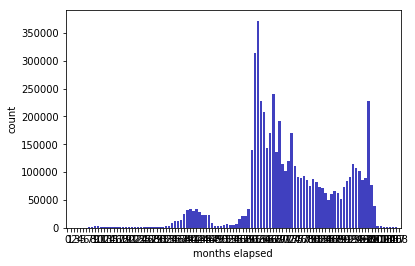

In [70]:
# plot purposes (whole data without truncating and
# without keeping only observations during the presidential campaign)
sns.barplot(x = "months elapsed", y="count", data=normal_dates_pd,
                   color="blue", saturation=.5)
plt.title('')
plt.xlabel('TimeResponse (sec) (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram'])